from https://www.kaggle.com/code/hugosjoberg/house-prices-prediction-using-keras

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler # Used for scaling of data
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
show_graphs = False

In [3]:
# Read in train data
try:
    df_listings = pd.read_csv('untidy_df_listings_v06.csv', index_col=0)
except:
    !wget https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/untidy_df_listings_v06.csv
    df_listings = pd.read_csv('untidy_df_listings_v06.csv', index_col=0)

In [4]:
df_listings.head()

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030472,0.101800,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049912,0.377380,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052298,0.233550,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.049910,0.034934,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077552,0.036010,NaN


# Prepare data
    Investigate what data that has a linear or some kind of relation to the sale price
    Drop the unimportant features or less unimportant features
    Drop features which has many NaN values

In [5]:
#descriptive statistics summary
df_listings['Price'].describe()

count     54067.000000
mean     416448.380528
std      113505.624206
min      100000.000000
25%      325000.000000
50%      425000.000000
75%      500000.000000
max      600000.000000
Name: Price, dtype: float64

In [6]:
#skewness and kurtosis
print("Skewness: %f" % df_listings['Price'].skew())
print("Kurtosis: %f" % df_listings['Price'].kurt())

Skewness: -0.220900
Kurtosis: -0.724044


    - Skewness means the top of the iceberg is not in the middle but rather towards left or right.
    - Kurtosis describe if the gaussian distrubution is very small and narrow or very wide

Let's have a  look at the missing data.

Let's display a % of the data that is missing from some columns.

In [7]:
#missing data
total = df_listings.isnull().sum().sort_values(ascending=False)
percent = (df_listings.isnull().sum()/df_listings.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
tenure.tenureType,3654,0.067583
bathrooms,3498,0.064698
bedrooms,1802,0.033329
location.latitude,10,0.000185
latitude_deviation,10,0.000185
Price,0,0.000000
nearestStation,0,0.000000
location.longitude,0,0.000000
longitude_deviation,0,0.000000


Some of theese features are of interest for us and they don't show a massive shortage of data so lets create mean data for those values.

In [8]:
df_listings = df_listings.fillna(df_listings.mean())
df_listings.describe()

/tmp/ipykernel_3750/1866876534.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_listings = df_listings.fillna(df_listings.mean())


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,54067.000000,54067.000000,54067.000000,54067.000000,54067.000000,54067.000000,54067.000000,54067.000000
mean,416448.380528,11.360145,1.181534,0.442075,51.496130,-0.106239,0.063545,0.133758
std,113505.624206,2107.308303,0.399652,1.049040,0.076643,0.718769,0.042990,0.706214
min,100000.000000,1.000000,1.000000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,325000.000000,1.000000,1.000000,0.221778,51.439082,-0.212965,0.027545,0.044160
50%,425000.000000,2.000000,1.000000,0.361208,51.499427,-0.105220,0.057208,0.098877
75%,500000.000000,3.000000,1.000000,0.553963,51.554061,-0.012998,0.093844,0.192164
max,600000.000000,490000.000000,12.000000,192.431869,51.683185,51.558746,0.201161,51.663966


In [9]:
# Do some basic outlier excluding

df_listings['location.latitude'] = pd.to_numeric(df_listings['location.latitude'], 'coerce').dropna().astype(float)

df_listings = df_listings[(df_listings['bedrooms'] <= 7)]
df_listings = df_listings[df_listings['bathrooms'] <= 5]

df_listings = df_listings[(df_listings['nearestStation'] <= 7.5)]

df_listings = df_listings[(df_listings['location.longitude'] <= 1)]
df_listings = df_listings[(df_listings['longitude_deviation'] <= 1)]

df_listings.describe()

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,52246.000000,52246.000000,52246.000000,52246.000000,52246.000000,52246.000000,52246.000000,52246.000000
mean,419770.462868,1.984764,1.186326,0.437750,51.496037,-0.114293,0.064434,0.124907
std,111988.997579,0.826213,0.400064,0.328342,0.077348,0.157060,0.042927,0.095646
min,100000.000000,1.000000,1.000000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,335000.000000,1.000000,1.000000,0.225128,51.437511,-0.212605,0.028596,0.044240
50%,425000.000000,2.000000,1.000000,0.365945,51.499239,-0.103647,0.058652,0.099856
75%,500000.000000,2.000000,1.000000,0.558825,51.555327,-0.010570,0.094620,0.193130
max,600000.000000,7.000000,5.000000,7.197700,51.683185,0.279726,0.201161,0.393095


# Prepare data
Right now I think we have an idea of what kind of data we are interested in and what data we don't think are useful for us. Let's build a pipeline for removing the data.

Let's reload the data so we can have a fresh start!

In [10]:
df_listings = pd.read_csv('untidy_df_listings_v06.csv', index_col=0)

Let's not log the data since a neural network is quite good at working with non-linear data. I also tested and verified that the model didn't perform better or worse if I logged the data before hand.

In [11]:
cols = ['Price','bedrooms','bathrooms','nearestStation','location.latitude','location.longitude','latitude_deviation','longitude_deviation']
features = ['bedrooms','bathrooms','nearestStation','location.latitude','location.longitude','latitude_deviation','longitude_deviation']
df_listings = df_listings[cols]

# Create dummy values
df_listings = pd.get_dummies(df_listings)

#filling NA's with the mean of the column:
df_listings = df_listings.fillna(df_listings.mean())

# Always standard scale the data before using NN
scale = StandardScaler()
X_listings = df_listings[features]
X_listings = scale.fit_transform(X_listings)

# Y is just the 'Price' column
y = df_listings['Price'].values

# split into train and test. Lots of data available so test can be small and most can be used for train
X_train, X_test, y_train, y_test = train_test_split(X_listings, y, test_size=0.005, random_state=101)
X_test.shape, y_test.shape

((271, 7), (271,))

In [12]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_squared_error', 
              metrics =[metrics.mae])
    return model

In [13]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                80        
                                                                 
 dense_1 (Dense)             (None, 30)                330       
                                                                 
 dense_2 (Dense)             (None, 40)                1240      
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 1,691
Trainable params: 1,691
Non-trainable params: 0
_________________________________________________________________


In [14]:
# REPLACED WITH NEXT # history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=150, batch_size=32)
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=150, batch_size=32)

Epoch 1/150
1345/1345 [==============================] - 9s 6ms/step - loss: 134324846592.0000 - mean_absolute_error: 336029.5000 - val_loss: 27994920960.0000 - val_mean_absolute_error: 135727.2969
Epoch 2/150
1345/1345 [==============================] - 7s 6ms/step - loss: 18021046272.0000 - mean_absolute_error: 105366.5703 - val_loss: 13631908864.0000 - val_mean_absolute_error: 95473.7109
Epoch 3/150
1345/1345 [==============================] - 7s 5ms/step - loss: 14408830976.0000 - mean_absolute_error: 95262.8750 - val_loss: 12399644672.0000 - val_mean_absolute_error: 91760.5000
Epoch 4/150
1345/1345 [==============================] - 7s 5ms/step - loss: 13476052992.0000 - mean_absolute_error: 92946.6250 - val_loss: 11885965312.0000 - val_mean_absolute_error: 90183.2422
Epoch 5/150
1345/1345 [==============================] - 7s 5ms/step - loss: 12973162496.0000 - mean_absolute_error: 91771.1641 - val_loss: 11597219840.0000 - val_mean_absolute_error: 89144.0625
Epoch 6/150
1345/1345

Let's investigate how well this model did!

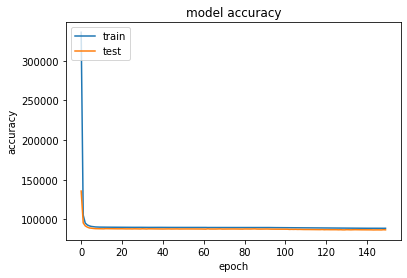

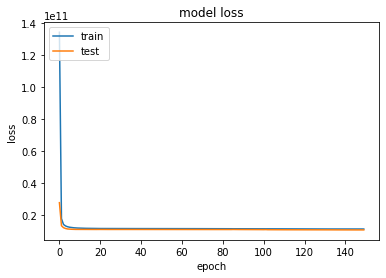

In [15]:
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This result is not very good and gives us a mean absolute error just above 20000 dollars. I beleive this model performs bad due to the fact that we have a quite small data-set becuase a neural network performs the best when having a big dataset. 

In [16]:
# Read in train data
try:
    df_listings = pd.read_csv('untidy_df_listings_v06.csv', index_col=0)
except:
    !wget https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/untidy_df_listings_v06.csv
    df_listings = pd.read_csv('untidy_df_listings_v06.csv', index_col=0)

In [17]:
scale = StandardScaler()
X_test = scale.fit_transform(X_test)

In [18]:
y_pred = model.predict(X_test)

from pandas import DataFrame

compare = np.hstack((y_test.reshape(-1,1), y_pred.reshape(-1,1)))
compare_df = DataFrame(compare, columns=['actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df.sort_values("diff 1 %", ascending=False)

9/9 [==============================] - 0s 3ms/step


,actual,predicted,difference,diff 1 %,diff 2 %
190,100000.0,674027.06250,574027.06250,574.027062,85.163800
163,150000.0,856870.37500,706870.37500,471.246917,82.494435
147,187500.0,898433.25000,710933.25000,379.164400,79.130336
220,152500.0,685706.68750,533206.68750,349.643730,77.760170
178,260000.0,900052.87500,640052.87500,246.174183,71.112808
...,...,...,...,...,...
5,350000.0,348638.87500,1361.12500,0.388893,0.390411
67,400000.0,398749.12500,1250.87500,0.312719,0.313700
145,395000.0,395371.59375,371.59375,0.094074,0.093986
157,370000.0,369677.59375,322.40625,0.087137,0.087213


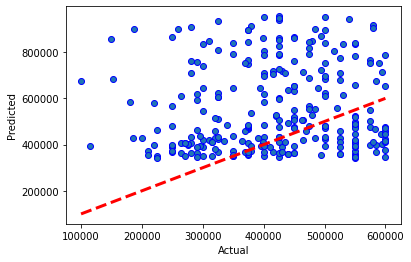

In [19]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
plt.ticklabel_format(style='plain')
plt.show()